In [2]:
# %%capture
# pip install econml shap "flaml[automl]" dill plotnine scikit-misc

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotnine as p9
import math
import scipy
import scipy.special
from statsmodels.api import OLS

In [5]:
df = pd.read_parquet('../../output/pretraining/representations_combo_df.parquet')
df.columns

Index(['mrn', 'ds', 'g_7dr', 'very_low_7dr', 'low_7dr', 'in_range_7dr',
       'high_7dr', 'very_high_7dr', 'gri_7dr', 'g_14dr', 'very_low_14dr',
       'low_14dr', 'in_range_14dr', 'high_14dr', 'very_high_14dr', 'gri_14dr',
       'night_very_low_7dr', 'night_low_7dr', 'night_high_7dr',
       'night_very_high_7dr', 'day_very_low_7dr', 'day_low_7dr',
       'day_high_7dr', 'day_very_high_7dr', 'time_worn_7dr', 'night_worn_7dr',
       'day_worn_7dr', 'gri_7dr_7d_delta', 'very_low_7dr_7d_delta',
       'low_7dr_7d_delta', 'in_range_7dr_7d_delta', 'very_high_7dr_7d_delta',
       'night_very_low_7dr_7d_delta', 'night_low_7dr_7d_delta',
       'night_high_7dr_7d_delta', 'delta_in_range_fw_7d', 'delta_gri_fw_7d',
       'sexF', 'public_insurance', 'english_primary_language', 'pop_pilot',
       'pop_4T_1', 'pop_4T_2', 'pop_TIPS', 'age', 'months_since_onset',
       'using_pump', 'using_aid', 'data_split', 'large_tir_drop', 'low_tir',
       'lows', 'very_lows', 'umap0', 'umap1', 'umap2', 

New features for filtering

In [6]:
# Drop rows with no flags
print(df.shape)
df = df[(df.low_tir+df.lows+df.very_lows+df.large_tir_drop)>0]
print(df.shape)

(196816, 82)
(129345, 82)


In [15]:
CGM_FLAG_VARS = ['large_tir_drop', 'low_tir', 'lows', 'very_lows']
CGM_CONT_VARS = ['very_low_7dr', 'low_7dr', 'high_7dr', 'very_high_7dr']
TS2VEC_VARS = ['ts2vec_0', 'ts2vec_1', 'ts2vec_2', 'ts2vec_3']

CLINICIAN_ACTION_REP = 'custom_treatment_v3'
EMBEDDING_ACTION_REP = 'km_treatment_4'

In [16]:
# P(A | flag) clinician action rep

melt_df = pd.melt(
    df[CGM_FLAG_VARS + [CLINICIAN_ACTION_REP, EMBEDDING_ACTION_REP]],
    id_vars=[CLINICIAN_ACTION_REP,EMBEDDING_ACTION_REP])

melt_df = melt_df.join(pd.get_dummies(melt_df[CLINICIAN_ACTION_REP], prefix='clinician_action'))
melt_df = melt_df.join(pd.get_dummies(melt_df[EMBEDDING_ACTION_REP], prefix='cluster_action'))

melt_df = melt_df[melt_df.value==1]
melt_df = melt_df.drop([CLINICIAN_ACTION_REP, EMBEDDING_ACTION_REP, 'clinician_action_0', 'cluster_action_0', 'value'], axis=1)

melt_df = melt_df.groupby('variable').mean().reset_index()

rename_map = {
    'custom_treatment_v3_0': 'treatment_0',
    'custom_treatment_v3_1': 'treatment_1',
    'custom_treatment_v3_2': 'treatment_2',
    'custom_treatment_v3_3': 'treatment_3',
    'custom_treatment_v3_4': 'treatment_4'
}

# Rename the one-hot encoded columns
melt_df = melt_df.rename(columns={
    'clinician_action_1': 'Message Treating Highs+Lows',
    'clinician_action_2': 'Message Treating Highs only',
    'clinician_action_3': 'Message Treating Lows only',
    'clinician_action_4': 'Other Message'
})

melt_df

,variable,Message Treating Highs+Lows,Message Treating Highs only,Message Treating Lows only,Other Message,cluster_action_1,cluster_action_2,cluster_action_3,cluster_action_4
0,large_tir_drop,0.020956,0.016206,0.001607,0.030246,0.044845,0.013901,0.001048,0.007684
1,low_tir,0.018941,0.010450,0.002033,0.030090,0.037238,0.015261,0.001306,0.006430
2,lows,0.020859,0.002721,0.017231,0.034635,0.045604,0.016108,0.001382,0.010408
3,very_lows,0.022559,0.002956,0.012447,0.032983,0.044146,0.015364,0.001595,0.008285


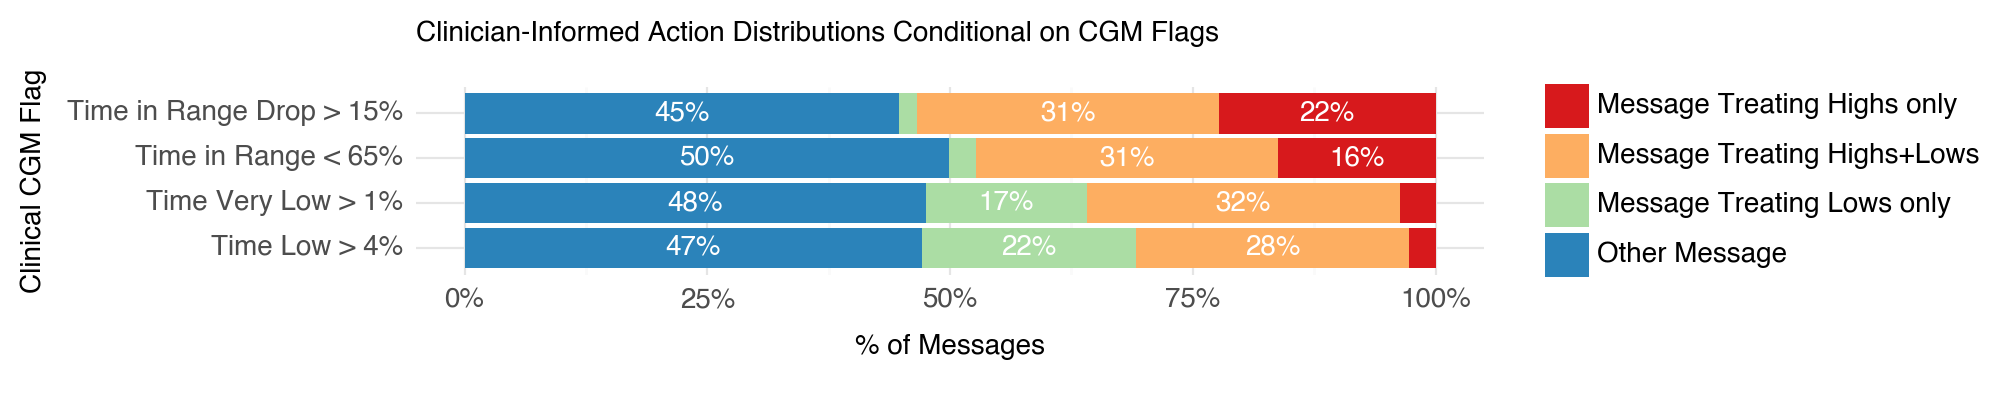

<Figure Size: (1000 x 200)>

In [17]:
# Stacked bars [clinician rep]

melt_df = pd.melt(
    df.query('received_message==1')[CGM_FLAG_VARS + [CLINICIAN_ACTION_REP]],
    id_vars=[CLINICIAN_ACTION_REP])
melt_df = melt_df[melt_df.value==1]
melt_df = melt_df.groupby([CLINICIAN_ACTION_REP, 'variable']).size().reset_index(name='count')
melt_df['proportion'] = melt_df.groupby('variable')['count'].transform(lambda x: x / x.sum())

melt_df['Action'] = melt_df[CLINICIAN_ACTION_REP].replace({
    1: 'Message Treating Highs+Lows',
    2: 'Message Treating Highs only',
    3: 'Message Treating Lows only',
    4: 'Other Message'
})

melt_df['Flag'] = melt_df['variable'].replace({
    'large_tir_drop': 'Time in Range Drop > 15%',
    'low_tir': 'Time in Range < 65%',
    'lows': 'Time Low > 4%',
    'very_lows': 'Time Very Low > 1%'
})

melt_df['proportion_text'] = melt_df['proportion'].apply(lambda x: f'{x*100:.0f}%' if x>0.05 else '')

from mizani.formatters import percent_format
p1 = (p9.ggplot(melt_df, p9.aes(x='Flag',y='proportion',fill='Action')) +
 p9.geom_bar(position="stack", stat="identity") + 
 p9.scale_y_continuous(labels=percent_format()) +
 p9.geom_text(p9.aes(label='proportion_text'), 
                  position=p9.position_stack(vjust=0.5), 
                  size=10, 
                  color='white') +
p9.labs(title='Clinician-Informed Action Distributions Conditional on CGM Flags',
          x='Clinical CGM Flag',
          y='% of Messages') +           
p9.theme_minimal() +
 p9.theme(
     figure_size=(10, 2),
     text=p9.element_text(size=10),
     legend_position='right',
    #  axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
    #  axis_text_y=p9.element_text(size=12),  # Customize y-axis text size and color
    #  axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
    #  axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
    #  strip_text_y=p9.element_text(size=12, rotation=0),
    #  strip_text_x=p9.element_text(size=12),
    #  plot_title=p9.element_text(size=16),
     legend_title=p9.element_blank(),  # Remove legend title
 ) +
 p9.scale_fill_brewer(type='div', palette='Spectral') +
 p9.guides(fill=p9.guide_legend(nrow=4)) + p9.coord_flip()
)

p1

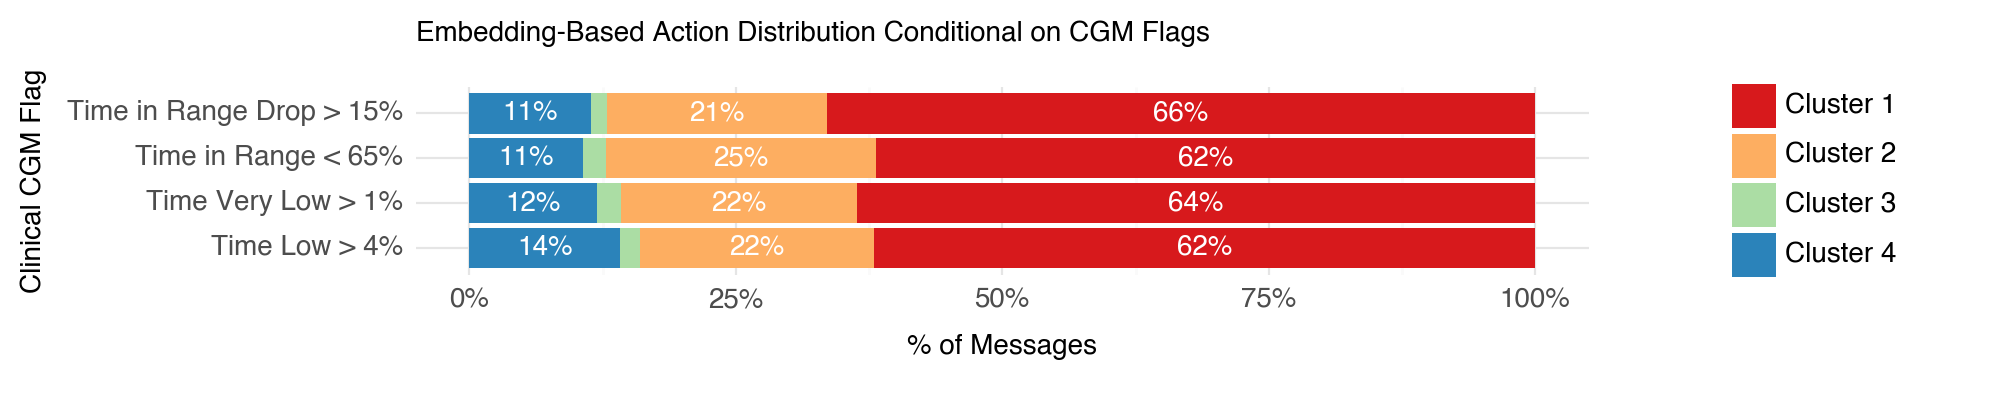

<Figure Size: (1000 x 200)>

In [18]:
# Stacked bars [auto rep]

melt_df = pd.melt(
    df.query(f'{EMBEDDING_ACTION_REP}>0')[CGM_FLAG_VARS + [EMBEDDING_ACTION_REP]],
    id_vars=[EMBEDDING_ACTION_REP])
melt_df = melt_df[melt_df.value==1]
melt_df = melt_df.groupby([EMBEDDING_ACTION_REP, 'variable']).size().reset_index(name='count')
melt_df['proportion'] = melt_df.groupby('variable')['count'].transform(lambda x: x / x.sum())

melt_df['Action'] = melt_df[EMBEDDING_ACTION_REP].replace({
    1: 'Cluster 1',
    2: 'Cluster 2',
    3: 'Cluster 3',
    4: 'Cluster 4'
})

melt_df['Flag'] = melt_df['variable'].replace({
    'large_tir_drop': 'Time in Range Drop > 15%',
    'low_tir': 'Time in Range < 65%',
    'lows': 'Time Low > 4%',
    'very_lows': 'Time Very Low > 1%'
})

melt_df['proportion_text'] = melt_df['proportion'].apply(lambda x: f'{x*100:.0f}%' if x>0.05 else '')

from mizani.formatters import percent_format

p2 = (p9.ggplot(melt_df, p9.aes(x='Flag',y='proportion',fill='Action')) +
 p9.geom_bar(position="stack", stat="identity") + 
 p9.scale_y_continuous(labels=percent_format()) +
 p9.geom_text(p9.aes(label='proportion_text'), 
                  position=p9.position_stack(vjust=0.5), 
                  size=10, 
                  color='white') +
p9.labs(title='Embedding-Based Action Distribution Conditional on CGM Flags',
          x='Clinical CGM Flag',
          y='% of Messages') +           
p9.theme_minimal() +
 p9.theme(
     figure_size=(10, 2),
     text=p9.element_text(size=10),
     legend_position='right',
    #  axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
    #  axis_text_y=p9.element_text(size=12),  # Customize y-axis text size and color
    #  axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
    #  axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
    #  strip_text_y=p9.element_text(size=12, rotation=0),
    #  strip_text_x=p9.element_text(size=12),
    #  plot_title=p9.element_text(size=16),
     legend_title=p9.element_blank(),  # Remove legend title
     legend_margin=30
 ) +
 p9.scale_fill_brewer(type='div', palette='Spectral') +
 p9.guides(fill=p9.guide_legend(nrow=4)) + p9.coord_flip()
)

p2

In [11]:
# Save
p1.save(filename='../../output/figures/temp_p1.pdf', width=10, height=2, units='in', dpi=300)
p2.save(filename='../../output/figures/temp_p2.pdf', width=10, height=2, units='in', dpi=300)

In [19]:
# Continous CGM variables

melt_df = pd.melt(
    df[CGM_CONT_VARS + TS2VEC_VARS + [CLINICIAN_ACTION_REP, EMBEDDING_ACTION_REP]],
    id_vars=[CLINICIAN_ACTION_REP,EMBEDDING_ACTION_REP])

melt_df = melt_df.join(pd.get_dummies(melt_df[CLINICIAN_ACTION_REP], prefix='clinician_action'))
melt_df = melt_df.join(pd.get_dummies(melt_df[EMBEDDING_ACTION_REP], prefix='cluster_action'))
melt_df = melt_df.drop([CLINICIAN_ACTION_REP, EMBEDDING_ACTION_REP, 'clinician_action_0', 'cluster_action_0'], axis=1)

melt_df = melt_df.groupby('variable').corr().reset_index()

melt_df = melt_df[melt_df.level_1 == 'value']
melt_df = melt_df.drop(['value','level_1'], axis=1)

melt_df['variable'] = pd.Categorical(
    melt_df['variable'], 
    categories=CGM_CONT_VARS + TS2VEC_VARS, ordered=True)
melt_df = melt_df.sort_values('variable')

melt_df

,variable,clinician_action_1,clinician_action_2,clinician_action_3,clinician_action_4,cluster_action_1,cluster_action_2,cluster_action_3,cluster_action_4
63,very_low_7dr,0.020891,-0.031935,0.071613,0.005945,0.022423,0.003240,0.006056,0.005385
9,low_7dr,0.018929,-0.042163,0.095773,0.011110,0.022909,0.006731,0.002273,0.013802
0,high_7dr,0.020247,0.044335,-0.066089,0.003627,0.012491,0.002251,0.002595,0.002668
54,very_high_7dr,-0.004472,0.010250,-0.050241,-0.021271,-0.020299,-0.000962,0.000454,-0.027905
18,ts2vec_0,0.002888,0.008027,-0.048195,-0.018168,-0.013027,-0.005852,0.003748,-0.023494
27,ts2vec_1,0.002536,0.001765,0.027347,0.018151,0.014695,0.007925,0.002726,0.016419
36,ts2vec_2,0.004070,-0.008059,-0.003852,-0.003716,-0.005045,0.004155,-0.000255,-0.006465
45,ts2vec_3,0.017964,-0.022427,0.046241,0.013604,0.018546,0.005354,-0.000004,0.013696
